In [6]:
import numpy as np
from numpy import sqrt, cos, sin
import matplotlib
import matplotlib.pyplot as plt

## Hyperelasticity 

The main objective of this Python notebook is to derive stress and elasticity tensors out of a strain energy function given in terms of invariants.

As explained in class, hyperelastic materials are those with an underlying strain energy potential. These materials have a stress field that is completely given by the current state of deformation and independently of the path of deformation. These materials are very useful to describe very common types of materials, rubbers in particular. 

We will split the notebook into three types of materials

* **Compressible, coupled material models**: Given the deformation gradient $\mathbf{F}$ and corresponding deformation quantities such as $\mathbf{C}=\mathbf{F}^T\mathbf{F}$, $\mathbf{b}=\mathbf{F}\mathbf{F}^T$, or derived strains from these tensors, we can have strain energies of the form $\Psi(I_i)$ where the $I_i$ are invariants of the deformation or strain tensors. For materials in this form the stress can be computed as $\mathbf{S}=2\partial\Psi/\partial \mathbf{C}=\partial \Psi/\partial \mathbf{E}$; $\mathbf{\sigma} = 2\mathbf{b}\partial \Psi/\partial \mathbf{b}$

* **Compressible or nearly incompressible decoupled material models**: the decoupling means we split the deformation into isochoric (or volume preserving, or distortional) and volumetric deformation (just volume change but no distorsion), $\mathbf{F} = (J^{1/3}\mathbf{I})({J}^{-1/3}\mathbf{F})$; we use the notation $\bar{\mathbf{F}}= {J}^{-1/3}\mathbf{F}$ for the isochoric part. The deformation and strain derived quantities from this part of the deformation are $\bar{\mathbf{C}} = \bar{\mathbf{F}}^T\bar{\mathbf{F}}$ etc. The strain energy is then given as a sum from the isochoric part and the volumetric part: $\Psi = \Psi_{iso}(\bar{I}_i)+\Psi_{vol}(J)$ where $\bar{I}_i$ are isochoric invariants. 

* **Fully incompressible materials**: For this $J=1$ and there is technically no split into isochoric and volumetric parts. Instead, the energy can be thought of as a component from the invariants plus a Lagrange multiplier constraint: $\Psi = \Psi(I_i)+p(J-1)$ where the field $p$ is a Lagrange multiplier field, i.e. an generalized force corresponding to the constraint. In practice exact incompressibility can only be ensured in very specific loading such as plane stress. More likely, incomporessible behavior will be enforced approximately. In those cases, there will be still a Lagrange multiplier field but then the isochoric invariants are used: $\Psi = \Psi(\bar{I}_i)+p(J-1)$ since $J~1$ but not exactly 1. 

We will deal with the first two cases in this lecture and ignore the third case. We will only come back to the third case in the wrap up module if we have time and there is interest. 

Also, note that we are not going to deal with material models in terms of the eigenvalues of the deformation but the interested reader is referred to the references in the course, e.g.

Holzapfel, G.A., 2002. Nonlinear solid mechanics: a continuum approach for engineering science. Meccanica, 37(4), pp.489-490.



### Example 1:  neo-Hookean 

We will start with a coupled neo-Hookean model as we have seen in class. The strain energy for this material is 

$$
\Psi = \frac{\mu}{2}(I_1 -3) - \mu \log (J) + \lambda (\frac{\log (J)}{2})^2 
$$

Where $\mu$ and $\lambda$ are material parameters called Lame constants. 
Recall the derivatives 

$$
\begin{aligned}
\frac{\partial I_1}{\partial \mathbf{C}} &= \mathbf{I}\\
\frac{\partial I_3}{\partial \mathbf{C}} &= I_3 \mathbf{C}^{-1}\\
\end{aligned}
$$ 

And noting that $I_3 = J^2$ 

then we have than the second Piola Kirchhoff stress tensor is 

$$
\mathbf{S} = 2\frac{\partial \Psi}{\partial \mathbf{C}} = \mu \mathbf{I} - \mu \mathbf{C}^{-1} + \lambda \log (J)\mathbf{C}^{-1}
$$

Alternatively, we can get the second Piola Kirchhoff stress tensor directly. Recall that the invariants of $\mathbf{C}$ and those of $\mathbf{b}$ are the same, so 

$$
\begin{aligned}
\frac{\partial I_1}{\partial \mathbf{b}} &= \mathbf{I}\\
\frac{\partial I_3}{\partial \mathbf{b}} &= I_3 \mathbf{b}^{-1}\\
\end{aligned}
$$ 

And then we get that the Cauchy stress is simply 

$$
J \mathbf{\sigma}=
2\mathbf{b}\frac{\partial \Psi}{\partial \mathbf{b}} = \mu \mathbf{b} - \mu \mathbf{I} + \lambda \log (J)\mathbf{b}
$$

Below we show: 

* Implementation of a function that takes in the deformation gradient and computes the second Piola Kirchhoff stress tensor 
* A function that transforms the second Piola Kirchhoff stress tensor to the Cauchy stress tensor 
* A function that computes the Cauchy stress tensor directly 
* A function that transforms the Cauchy stress tensor to the first Piola Kirchhoff stress tensor 
* A function that computes the stress for a deformation gradient corresponding to applied biaxial deformation (requies the solution of $\sigma_{33}=0$ with Newton-Raphson) 

In [28]:
def evalS_neoHooke(F,mat_param):
    # mat param is an array with the parameters for this material 
    mu_NH = mat_param[0] #shear modulus 
    lam_NH = mat_param[1] # bulk modulus 
    C = np.dot(F.transpose(),F)
    Cinv = np.linalg.inv(C)
    J = np.linalg.det(F)
    S = mu_NH*np.eye(3)-mu_NH*Cinv+lam_NH*np.log(J)*Cinv
    return S

def S2sigma(F,S):
    J = np.linalg.det(F)
    sigma = (1.0/J)*np.dot(F,np.dot(S,F.transpose()))
    return sigma 

def evalsigma_neoHooke(F,mat_param):
    # mat param is an array with the parameters for this material 
    mu_NH = mat_param[0] #shear modulus 
    lam_NH = mat_param[1] # bulk modulus 
    b = np.dot(F,F.transpose())
    J = np.linalg.det(F)
    sigma = (1.0/J)*(mu_NH*b-mu_NH*np.eye(3)+lam_NH*np.log(J)*b)
    return sigma 

def sigma2P(F,sigma):
    J = np.linalg.det(F)
    Finv = np.linalg.inv(F)
    P = J*np.dot(sigma,Finv.transpose())
    return P

def evalsigma_biaxial_neoHooke(lam1,lam2,mat_param):
    # for biaxial, need to solve sigma_33 = 0 with Newton-Raphson 
    # that means guessing something for lambda_3, evaluating sigma_33 (which won't be zero) and iteratively
    # update lambda_3 until we get to sigma_33 = 0 
    resnorm = 1
    iter = 0
    iter_max = 20
    tol = 1e-5
    # this is the initial guess for lam3, might as well assume incompressible 
    lam3 = 1/(lam1*lam2) 
    while resnorm>tol and iter<iter_max:
        F = np.array([[lam1,0,0],[0,lam2,0],[0,0,lam3]])
        # given this F, need to ask for S, just call my function 
        sigma = evalsigma_neoHooke(F,mat_param)
        # the 'residual' is just the 33 entry of the tensor 
        resnorm = np.abs(sigma[2,2])
        # need to take derivative of the residual to do Newton-Raphson.
        # It is not that bad, I need partial S_33/partial lam3 
        # but I don't want to and numerical derivative will do just fine for this example 
        # In general I would recommend numerical derivative for something like this which doesnt take
        # much time, BUT, if you need to evaluate biaxial deformation for thousands of deformations or
        # parameters, then do consider switching to the analytical version, it will save you time 
        # One way to do so is with the JAX package in Python which will let you do automatic diff
        # so you dont have to work out the derivative yourself 
        # for numerical derivative, eval near lam3 
        eps = 1e-7
        lam3_plus = lam3 + eps
        Fplus = np.array([[lam1,0,0],[0,lam2,0],[0,0,lam3_plus]])
        sigmaplus = evalsigma_neoHooke(Fplus,mat_param)
        lam3_minus = lam3 - eps
        Fminus = np.array([[lam1,0,0],[0,lam2,0],[0,0,lam3_minus]])
        sigmaminus = evalsigma_neoHooke(Fminus,mat_param)
        dresdlam3 = (sigmaplus[2,2]-sigmaminus[2,2])/(2*eps)
        # update guess 
        lam3 = lam3 - sigma[2,2]/dresdlam3 
    if iter>=iter_max:
        print('didnt converge the NR, resnorm = ',resnorm)
    return sigma,lam3



In [17]:
# Let's just evaluate the biaxial deformation, make sure it works 
n_lam = 50
# just some biaxial deformation
lam1_vec = np.linspace(1,1.2,n_lam)
lam2_vec = np.linspace(1,1.1,n_lam)
# material parameters 
mat_param = [1.,10.] #MPa
# empty arrays for sigma stress and lam3
sigma_vec = np.zeros((n_lam,3)) #only two components to keep track of, but saving sigma_33 too just to check 
lam3_vec = np.zeros((n_lam))
for i in range(n_lam):
    lam1 = lam1_vec[i]
    lam2 = lam2_vec[i]
    sigma,lam3 =  evalsigma_biaxial_neoHooke(lam1,lam2,mat_param)
    sigma_vec[i,0] = sigma[0,0]
    sigma_vec[i,1] = sigma[1,1]
    sigma_vec[i,2] = sigma[2,2]
    lam3_vec[i] = lam3

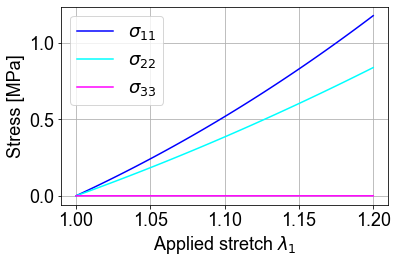

In [18]:
# plot stresses as a function of lambda 1
font = {'family' : 'Arial',
        'size'   : 18}
matplotlib.rc('font', **font)
plt.plot(lam1_vec,sigma_vec[:,0],label=r'$\sigma_{11}$',color=[0,0,1])
plt.plot(lam1_vec,sigma_vec[:,1],label=r'$\sigma_{22}$',color=[0,1,1])
plt.plot(lam1_vec,sigma_vec[:,2],label=r'$\sigma_{33}$',color=[1,0,1])
plt.legend(loc=2)
plt.xlabel(r'Applied stretch $\lambda_1$')
plt.ylabel('Stress [MPa]')
plt.grid()
plt.tight_layout()

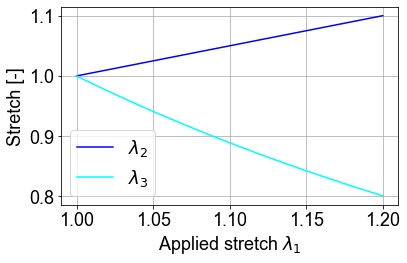

In [22]:
# plot the other stretches as a function of lambda 1
# note, that even though we are prescribing BOTH lam1 and lam2, in reality there is only ONE degree of freedom
# think of this biaxial test as a deformation depending on time, there is a loading curve over time, 
# so there is really only one degree of freedom, you can think lam1(t) and lam2(t) are given functions of time 
# or, alternative, just pick either lam1 or lam2 as independent to plot the other variables 
font = {'family' : 'Arial',
        'size'   : 18}
matplotlib.rc('font', **font)
plt.plot(lam1_vec,lam2_vec,label=r'$\lambda_{2}$',color=[0,0,1])
plt.plot(lam1_vec,lam3_vec,label=r'$\lambda_{3}$',color=[0,1,1])
plt.legend(loc=3)
plt.xlabel(r'Applied stretch $\lambda_1$')
plt.ylabel('Stretch [-]')
plt.grid()
plt.tight_layout()

### Decoupled neo-Hookean material 

The previous model was in terms of the full invariant $I_1$. However, in many cases it is convenient to isolate the contributions to the energy from volumetric changes from those from distorsional deformation. The isochoric-deviatoric split is 

$$
\mathbf{F} = \left(J^{1/3}\mathbf{I}\right)\left(J^{-1/3}\mathbf{F}\right)
$$

The second part of this split is volume-preserving 

$$
\hat{\mathbf{F}} = J^{-1/3}\mathbf{F}
$$

In other words, the determinant of this second part is $\det(\hat{\mathbf{F}})=1$. The energy is thus decomposed into two contributions 

$$
\Psi = \Psi_{iso}(\hat{\mathbf{F}}) + \Psi_{vol}(J)
$$

For the uncoupled neo Hookean we have 

$$
\Psi_{iso} = \frac{\mu}{2} (\bar{I}_1-3)
$$

where $\bar{I}_1$ is the first isochoric invariant, i.e. $\bar{I}_1 = \mathrm{tr}\hat{\mathbf{C}}$ and $\hat{\mathbf{C}} = \hat{\mathbf{F}}^T\hat{\mathbf{F}}$ 

While the volumetric part is actually not exclusive for the neo-Hookean material but the same volumetric energy is used for different material models. One classical example is 

$$
\Psi_{vol} = \frac{K}{2}(J-1)^2
$$

with $K$ the bulk modulus. 

The definition of the stress does not change. For example, the second Piola Kirchhoff stress is still 

$$
\mathbf{S} = 2\frac{\partial \Psi}{\partial \mathbf{C}}
$$

and the Cauchy stress is still 

$$
J\mathbf{\sigma} = 2\mathbf{b}\frac{\partial \Psi}{\partial \mathbf{b}}
$$

But this means you have to be careful with the derivatives of the isochoric portion, because you have $\Psi(\bar{I}_1)$ for example, and NOT $\Psi({I}_1)$, so to get derivatives with respect to $\mathbf{C}$ there are several ways. For example, you can use chain rule and do: 

$$
2\frac{\Psi_{iso}(\bar{I}_1)}{\partial \mathbf{C}} = 2\frac{\partial \Psi_{iso}(\bar{I}_1)}{\partial \bar{I}_1}\left(\frac{\partial \bar{I}_1}{\partial I_1} \frac{\partial I_1}{\partial \mathbf{C}} +\frac{\partial \bar{I}_1}{\partial J} \frac{\partial J}{\partial \mathbf{C}} \right)
$$

Or, equivalently 

$$
2\frac{\Psi_{iso}(\bar{I}_1)}{\partial \mathbf{C}} = 2\frac{\partial \Psi_{iso}(\bar{I}_1)}{\partial \hat{\mathbf{C}}} : \frac{\partial \hat{\mathbf{C}}}{\partial \mathbf{C}}
$$

Where the fourth order tensor $\frac{\partial \hat{\mathbf{C}}}{\partial \mathbf{C}}$ is kind of a projection tensor. 

Alternatively, you can try to put everything directly in terms of the basic invariants. In other words, try to find the expression for $\bar{I}_1$ in terms of $I_1$ and $J$. Turns out this is easy 

$$
\bar{I}_1  = J^{-2/3}I_1
$$

so, for example, for the uncoupled neo Hookean material the isochoric energy becomes 

$$
\Psi_{iso}(\bar{I}_1) = \Psi_{iso}({I}_1,J)  = \frac{\mu}{2}(J^{-2/3}I_1 - 3)
$$

so now you can compute directly the derivative $\partial \Psi_{iso}/\partial \mathbf{C}$

$$
2\frac{\Psi_{iso}(\bar{I}_1)}{\partial \mathbf{C}} = 2\frac{\Psi_{iso}({I}_1,J)}{\partial \mathbf{C}} = 2\frac{\Psi_{iso}({I}_1,J)}{\partial I_1}\frac{\partial I_1}{\partial \mathbf{C}} +  2\frac{\Psi_{iso}({I}_1,J)}{\partial J}\frac{\partial J}{\partial \mathbf{C}} 
$$

All these methods lead to the same stress tensor. Also, these strategies apply for both the second Piola Kirchhoff stress tensor as well as for the Cauchy stress tensor. 

The volumetric part is only a function of the Jacobian, so the stress contribution from this term is simply 

$$
\mathbf{S}_{vol} = 2\frac{\partial \Psi_{vol}(J)}{\partial \mathbf{C}} = J \frac{\partial \Psi_{vol}(J)}{\partial J} \mathbf{C}^{-1}
$$

You will often find the notation $p={\partial \Psi_{vol}(J)}/{\partial J}$. Note that this $p$ is not an independent variable, it is a function of $J$, that is $p(J)$. This is in contrast with *exact* incomressible materials for which there is a pressure $p$ but it is an *independent* variable.  

Finally, to close this section, the stress for the uncoupled neo Hookean material is 


$$
\mathbf{S} = \mu J^{-2/3}\mathbf{I}  - \frac{1}{3} \mu J^{-2/3}I_1\mathbf{C}^{-1} + 2KJ(J-1)  \mathbf{C}^{-1}
$$

Below we show

* Function to compute $\mathbf{S}$ given an arbitrary deformation gradient 
* Function to compute the stress from an equi-biaxial deformation by solving $\sigma_{33}=0$ with Newton-Raphson

Note that transformations between the different stress forms follow the same rules as before, no change here 

In [29]:
def evalS_neoHooke_uc(F,mat_param):
    # mat param is an array with the parameters for this material 
    mu_NH = mat_param[0] #shear modulus 
    K_NH = mat_param[1] # bulk modulus 
    # I'm going to use the derivation from above in which I actually started with the isochoric and volumetric
    # splits, but I ended up expressing everything in terms of the full C
    # as noted in the notes, this is not the only way to do things. Many textboks actually do the whole
    # derivation with the isochoric invariants and the projection tensor partial Chat/partial C, but
    # I have the impression that it might be easier to substitute all the isochoric parts in terms of the full
    # C tensor and J and then to just treat this as a regular strain energy function
    J = np.linalg.det(F)    
    C = np.dot(F.transpose(),F)
    Cinv = np.linalg.inv(C)
    I1 = C[0,0] + C[1,1] + C[2,2]
    S = mu_NH*J**(-2./3.)*np.eye(3)-1./3.*mu_NH*J**(-2./3.)*I1*Cinv+K_NH*J*(J-1)*Cinv
    return S 


def evalsigma_neoHooke_uc(F,mat_param):
    # rather than coding this directly F, let's use the second Piola Kirchhoff function and
    # the function to compute sigma from S 
    S = evalS_neoHooke_uc(F,mat_param)
    sigma = S2sigma(F,S)
    return sigma 


def evalsigma_biaxial_neoHooke_uc(lam1,lam2,mat_param):
    # just copying the code from the coupled material model with a few modifications 
    resnorm = 1
    iter = 0
    iter_max = 20
    tol = 1e-5
    lam3 = 1/(lam1*lam2) 
    while resnorm>tol and iter<iter_max:
        F = np.array([[lam1,0,0],[0,lam2,0],[0,0,lam3]])
        # given this F, need to ask for S, just call my function 
        sigma = evalsigma_neoHooke_uc(F,mat_param)
        # the 'residual' is just the 33 entry of the tensor 
        resnorm = np.abs(sigma[2,2])
        # for numerical derivative, eval near lam3 
        eps = 1e-7
        lam3_plus = lam3 + eps
        Fplus = np.array([[lam1,0,0],[0,lam2,0],[0,0,lam3_plus]])
        sigmaplus = evalsigma_neoHooke_uc(Fplus,mat_param)
        lam3_minus = lam3 - eps
        Fminus = np.array([[lam1,0,0],[0,lam2,0],[0,0,lam3_minus]])
        sigmaminus = evalsigma_neoHooke_uc(Fminus,mat_param)
        dresdlam3 = (sigmaplus[2,2]-sigmaminus[2,2])/(2*eps)
        # update guess 
        lam3 = lam3 - sigma[2,2]/dresdlam3 
    if iter>=iter_max:
        print('didnt converge the NR, resnorm = ',resnorm)
    return sigma,lam3

In [30]:
# Let's just evaluate the biaxial deformation, make sure it works 
n_lam = 50
# just some biaxial deformation
lam1_vec = np.linspace(1,1.2,n_lam)
lam2_vec = np.linspace(1,1.1,n_lam)
# material parameters 
mat_param = [1.,10.] #MPa
# empty arrays for sigma stress and lam3
sigma_vec = np.zeros((n_lam,3)) #only two components to keep track of, but saving sigma_33 too just to check 
lam3_vec = np.zeros((n_lam))
for i in range(n_lam):
    lam1 = lam1_vec[i]
    lam2 = lam2_vec[i]
    sigma,lam3 =  evalsigma_biaxial_neoHooke_uc(lam1,lam2,mat_param)
    sigma_vec[i,0] = sigma[0,0]
    sigma_vec[i,1] = sigma[1,1]
    sigma_vec[i,2] = sigma[2,2]
    lam3_vec[i] = lam3

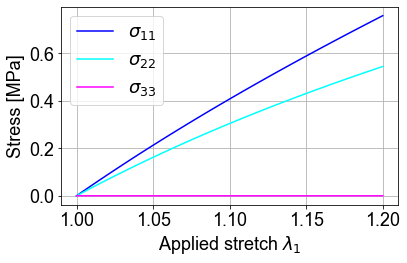

In [31]:
# plot stresses as a function of lambda 1
font = {'family' : 'Arial',
        'size'   : 18}
matplotlib.rc('font', **font)
plt.plot(lam1_vec,sigma_vec[:,0],label=r'$\sigma_{11}$',color=[0,0,1])
plt.plot(lam1_vec,sigma_vec[:,1],label=r'$\sigma_{22}$',color=[0,1,1])
plt.plot(lam1_vec,sigma_vec[:,2],label=r'$\sigma_{33}$',color=[1,0,1])
plt.legend(loc=2)
plt.xlabel(r'Applied stretch $\lambda_1$')
plt.ylabel('Stress [MPa]')
plt.grid()
plt.tight_layout()

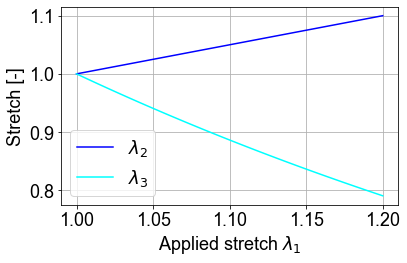

In [32]:
font = {'family' : 'Arial',
        'size'   : 18}
matplotlib.rc('font', **font)
plt.plot(lam1_vec,lam2_vec,label=r'$\lambda_{2}$',color=[0,0,1])
plt.plot(lam1_vec,lam3_vec,label=r'$\lambda_{3}$',color=[0,1,1])
plt.legend(loc=3)
plt.xlabel(r'Applied stretch $\lambda_1$')
plt.ylabel('Stretch [-]')
plt.grid()
plt.tight_layout()

### Incompressible neo Hookean material 

In some cases we want to enforce incompressible behavior exactly, $J=1$. In such cases there is no isochoric-volumetric split, and there is no volumetric energy and in principle the energy is just a function of the other invariants and not $J$, just a function of $I_1$ and $I_2$. For example, for incompressible neo-Hookean you get only 

$$
\Psi(I_1) = \frac{\mu}{2}(I_1-3)
$$

However, there is something hidden here: how do we guarantee that $J=1$? We must somehow impose this *constraint*. There is a way of imposing constraints when you do optimization problems and it is called the method of Lagrange multipliers. We can discuss more in class, but in summary you can think that the problem of deforming an incompressible hyperelastic solid can be stated as: *minimize the strain energy of the solid given the constraint J=1*. This is what is called a *constrained optimization problem*. But those are difficult to do. Instead, to turn this to an *uncsontrained optimization problem* we can change the function to minimize by adding an additional variable, a Lagrange multiplier. The problem becomes 

$$
minimize\; \Psi^* = \Psi + p(J-1)
$$

where the $\Psi^*$ is the new function to minimize, which includes the strain energy plus this new variable $p$ times the constraint. The $p$ variable is the Lagrange multiplier. The problem is to minimize $\Psi^*$ without any constraints. How can it be? Well, we are minimizing a problem that includes not just the deformation, but also the new variable $p$, and it can be shown that minimizing this extended problem is equivalent to the original problem. 

The stress comes from taking derivatives with respect to the deformation, as always

$$
\mathbf{S} = 2\frac{\partial \Psi^*}{\partial \mathbf{C}} = 2\frac{\partial \Psi}{\partial \mathbf{C}} + p\mathbf{C}^{-1}
$$

In general, given an arbitrary deformation gradient $\mathbf{F}$, I can't come up with a function that can compute the stress. First of all, I can't have arbitrary $\mathbf{F}$, I can only take a $\mathbf{F}$ with $\det(\mathbf{F})=1$, and then I also need to compute $p$. Let's go back to the initial way we were discussing the problem, as a minimization problem for the deformation of a solid. We need to consider boundary conditions. For example, let's say we want to do biaxial deformation for a thin speciment, then we can say that our degrees of freedom are $\lambda_1, \lambda_2$ the in plane stretches, and the normal stress $\sigma_{33}=0$. The unknowns are the stresses $\sigma_{11},\sigma_{22}$ and the out of plane stretch $\lambda_3$. Minimization of $\Psi^*$ over $\lambda_3, p$ leads to two equations

$$
\begin{aligned}
\frac{\partial \Psi^*}{\partial \lambda_3} = 0\\
\frac{\partial \Psi^*}{\partial p}=0
\end{aligned}
$$

Turns out that the first equation is just $S_{33}(p,\lambda_1,\lambda_2,\lambda_3) = 0$ and the second equation is just $J=\lambda_1 \lambda_2 \lambda_3 = 1$. So, for this simple type of loading we can find easily the values of $p$ and $\lambda_3$ that minimize $\Psi^*$ given boundary conditions. For a body with more complicated boundary conditions it is not easy. Just imagine that even without the constraint you have a nonlinear problem trying to minimize $\Psi$ by finding the strain field $\mathbf{C}$. Now we have to solve two equations simultaneously to get both the deformation field $\mathbf{C}$ as well as the pressure field $p$. We might go back to incompressible elasticity toward the end of the course if we have time. 

Below we

* Code an incompressible neo-Hookean material for biaxial deformation only 



In [33]:
def evalsigma_biax_neoHooke_ic(lam1,lam2,mat_param):
    # only one material parameter for the incompressible case
    mu_NH = mat_param[0] #shear modulus 
    # since it is incompressible we can directly get lam3 
    lam3 = 1./(lam1*lam2)
    F = np.array([[lam1,0,0],[0,lam2,0],[0,0,lam3]])
    b = np.dot(F,F.transpose())
    # for the pressure, recall the full S stress tensor looks like
    # S = mu*I - p*Cinv
    # and the corresponding sigma stress tensor looks like 
    # sigma = mu*b -p*I 
    # we can use either one. Note that the equation we need to solve is 
    # sigma_33 = 0 = mu*b_33 - p 
    # we don't need Newton Raphson to solve for p
    p = mu_NH*b[2,2]
    sigma = mu_NH*b -p*np.eye(3)
    return sigma, lam3, p

In [35]:
n_lam = 50
# just some biaxial deformation
lam1_vec = np.linspace(1,1.2,n_lam)
lam2_vec = np.linspace(1,1.1,n_lam)
# material parameters, only one for incompressible  
mat_param = [1.] #MPa
# empty arrays for sigma stress and lam3
sigma_vec = np.zeros((n_lam,3)) #only two components to keep track of, but saving sigma_33 too just to check 
lam3_vec = np.zeros((n_lam))
# for incompressible need to solve for 'p' as additional unknown
p_vec = np.zeros((n_lam))
for i in range(n_lam):
    lam1 = lam1_vec[i]
    lam2 = lam2_vec[i]
    sigma,lam3,p =  evalsigma_biax_neoHooke_ic(lam1,lam2,mat_param)
    sigma_vec[i,0] = sigma[0,0]
    sigma_vec[i,1] = sigma[1,1]
    sigma_vec[i,2] = sigma[2,2]
    lam3_vec[i] = lam3
    p_vec[i] = p

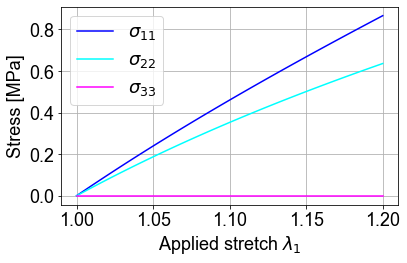

In [36]:
# plot stresses as a function of lambda 1
font = {'family' : 'Arial',
        'size'   : 18}
matplotlib.rc('font', **font)
plt.plot(lam1_vec,sigma_vec[:,0],label=r'$\sigma_{11}$',color=[0,0,1])
plt.plot(lam1_vec,sigma_vec[:,1],label=r'$\sigma_{22}$',color=[0,1,1])
plt.plot(lam1_vec,sigma_vec[:,2],label=r'$\sigma_{33}$',color=[1,0,1])
plt.legend(loc=2)
plt.xlabel(r'Applied stretch $\lambda_1$')
plt.ylabel('Stress [MPa]')
plt.grid()
plt.tight_layout()

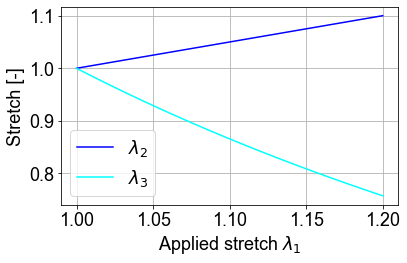

In [37]:
font = {'family' : 'Arial',
        'size'   : 18}
matplotlib.rc('font', **font)
plt.plot(lam1_vec,lam2_vec,label=r'$\lambda_{2}$',color=[0,0,1])
plt.plot(lam1_vec,lam3_vec,label=r'$\lambda_{3}$',color=[0,1,1])
plt.legend(loc=3)
plt.xlabel(r'Applied stretch $\lambda_1$')
plt.ylabel('Stretch [-]')
plt.grid()
plt.tight_layout()

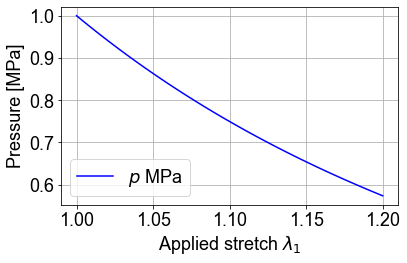

In [38]:
# for incompressible we also have the pressure as an uknown, so let's plot it 
font = {'family' : 'Arial',
        'size'   : 18}
matplotlib.rc('font', **font)
plt.plot(lam1_vec,p_vec,label=r'$p$ MPa',color=[0,0,1])
plt.legend(loc=3)
plt.xlabel(r'Applied stretch $\lambda_1$')
plt.ylabel('Pressure [MPa]')
plt.grid()
plt.tight_layout()

### Mooney Rivlin material (activity)



Consider the strain energy 

$$
\Psi = c_1 (\bar{I}_1 - 3) + c_2(\bar{I}_2 - 3) + K(J-1)^2
$$

where the $\bar{I}_1,\bar{I}_2$ are the isochoric invariants $\bar{I}_1 = J^{-2/3}I_1,\bar{I}_2 = J^{-4/3}I_2$

* Derive the expression for the second Piola Kirchhoff stress tensor, the Cauchy stress tensor, and the first Piola Kirchhoff stress tensor 
* Code a function to evaluate the stresses for an arbitrary deformation gradient $\mathbf{F}$
* Code a function to evaluate the stresses for uniaxial deformation (note, you need to use Newton-Raphson to solve for $\sigma_{22}=\sigma_{33}=0$ ) 
* Code a function to evaluate the stresses for biaxial deformation (note, you need to use Newton-Raphson to solve for $\sigma_{33}=0$)

